In [1]:
import os
os.chdir("../../")

In [2]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns
import distrax
from datasets import sin_data
import tensorflow_probability.substrates.jax as tfp

from models import gaussian_mlp 
from utilities.fits import fit
from utilities.gmm import gmm_mean_var

In [3]:
X, y, x_test_1, y_test_1, x_test_2, y_test_2 = sin_data.load_data()

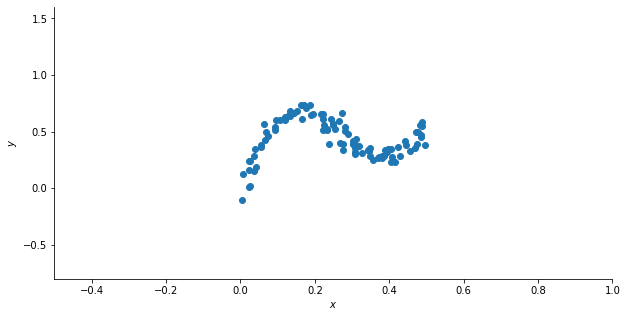

In [4]:
plt.figure(figsize=(10,5))
plt.scatter(X,y)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
sns.despine()
plt.show()

In [5]:
model = gaussian_mlp.gmlp(features=[32, 32], activations=[nn.elu, nn.elu], dropout_rate=[0.03, 0.03])

In [6]:
params = model.init(jax.random.PRNGKey(0), X, True)

In [7]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : False
}

In [8]:
params, loss = fit(model, params, auxs, learning_rate=0.01, epochs=2000, verbose=True)

Loss step 0:  0.7978813
Loss step 200:  -0.49085876
Loss step 400:  -0.8165698
Loss step 600:  -0.8924639
Loss step 800:  -1.11016
Loss step 1000:  -1.1769655
Loss step 1200:  -1.0889825
Loss step 1400:  -1.1899495
Loss step 1600:  -1.1219758
Loss step 1800:  -1.0575556


In [9]:
x = jnp.linspace(0,0.5,100).reshape((-1,1))

In [10]:
# mean, sigma = model.apply(params, X, dropout=True)
y_hat = model.apply(params, x, True)

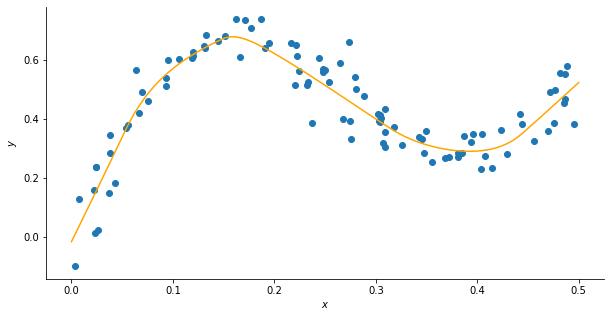

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(X, y)
plt.plot(x, y_hat[0], color="orange")
plt.xlabel("$x$")
plt.ylabel("$y$")
sns.despine()
plt.show()

In [12]:
# x_orig  = jnp.sort(X[:,0]).reshape(100,1)

In [13]:
# x_stack = jnp.concatenate([x_test_1, x_orig, x_test_2], axis = 0 )

In [14]:
# n_stacks = 100
# mean_stacks = []
# sigma_stacks = []
# for i in range(n_stacks):
#     y_stack = model.apply(params, x_stack, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
#     mean_stacks.append(y_stack[0])
#     sigma_stacks.append(y_stack[1])

## MC_Dropout

In [13]:
x = jnp.linspace(-0.5, 1, 200).reshape(-1,1)
n_stacks = 100
mean_stacks = []
sigma_stacks = []
for i in range(n_stacks):
    y_stack = model.apply(params, x, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
    mean_stacks.append(y_stack[0])
    sigma_stacks.append(y_stack[1])

In [15]:
mean, sigma = gmm_mean_var(mean_stacks, sigma_stacks)

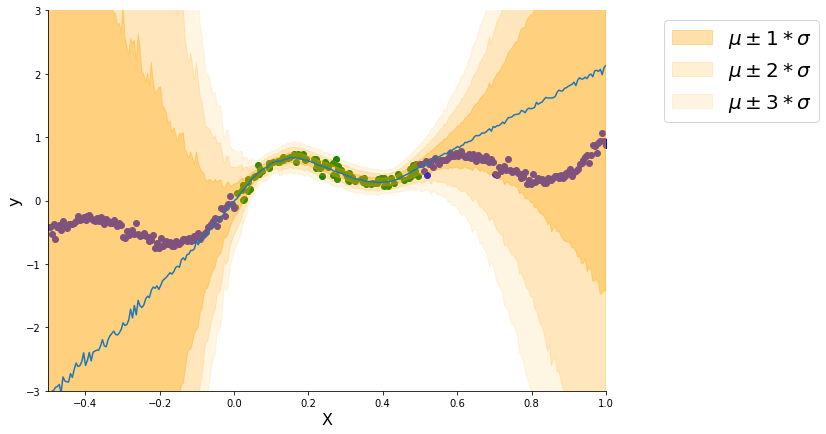

In [16]:
plt.figure(figsize=(10,7))
plt.scatter(X, y, c="g")
plt.scatter(x_test_1, y_test_1, c="b")
plt.scatter(x_test_2, y_test_2, c="b")
plt.plot(x_stack, mean)

for i in range(1,4):
    plt.fill_between(x_stack.squeeze(), mean - i*sigma, mean + i*sigma, color="orange", alpha = 1/(i*3), label = f"$\mu \pm {i}*\sigma$")
plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-0.5, 1.0)
plt.ylim(-3,3)
plt.savefig("guassin_mlp_dropout1.pdf",bbox_inches="tight")